<a href="https://colab.research.google.com/github/giacomominello/AI4S/blob/master/AI4S1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARTIFICIAL INTELLIGENCE FOR SECURITY - Assignment: Analysing Network Traffic

Group: 

Let's start by importing some libraries and loading some extensions. 

In [0]:
import pandas as pd #https://pandas.pydata.org/pandas-docs/stable/index.html
import numpy as np #https://numpy.org/devdocs/ 
import time 
import seaborn as sns
import matplotlib.pyplot as plt #https://matplotlib.org/api/pyplot_api.html
from ipywidgets import widgets #https://ipywidgets.readthedocs.io/en/latest/
from ipywidgets import interact #"It's a surprise tool that will help us later" 
%load_ext google.colab.data_table
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import check_random_state
random_state = np.random.RandomState(42) #should allow us to have deterministic results (up to roundoff error), we may need to pass this random_state instance to the generator

### First load the dataset for week 1 into a python notebook.
- We will use data from week 1 for training a system and keep the week 2 data for testing purposes only.

In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
file_id = '1Gjcq50EpQOH-t-dwQVRP6MmO7JRiRDUf'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CIDDS-001-internal-week1_10pcSample.csv')  
df = pd.read_csv('CIDDS-001-internal-week1_10pcSample.csv',index_col=[0])



In [0]:
df.head(100)

,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,attackID,attackDescription
23,2017-03-15 00:01:17.728,0.047,TCP,192.168.220.16,45586,10000_35,443.0,5,906,1,.AP.S.,0,normal,---,---,---
36,2017-03-15 00:01:18.457,0.170,TCP,10003_195,80,192.168.220.16,48286.0,3,908,1,.AP.S.,32,normal,---,---,---
30,2017-03-15 00:01:18.511,0.003,TCP,10002_113,443,192.168.220.16,49062.0,2,1089,1,.AP...,32,normal,---,---,---
46,2017-03-15 00:01:22.400,0.000,TCP,EXT_SERVER,8082,192.168.220.15,37039.0,1,212,1,.AP...,32,normal,---,---,---
51,2017-03-15 00:01:24.152,0.266,TCP,192.168.200.9,52290,EXT_SERVER,8082.0,2,319,1,.AP...,0,normal,---,---,---
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,2017-03-15 00:06:10.876,0.000,UDP,DNS,53,192.168.220.16,36031.0,2,565,1,......,0,normal,---,---,---
954,2017-03-15 00:06:21.221,0.323,TCP,192.168.220.16,48573,10003_195,80.0,5,2408,1,.AP.S.,0,normal,---,---,---
947,2017-03-15 00:06:21.349,0.000,UDP,DNS,53,192.168.220.16,42319.0,2,565,1,......,0,normal,---,---,---
949,2017-03-15 00:06:21.575,0.000,UDP,DNS,53,192.168.220.16,49715.0,2,565,1,......,0,normal,---,---,---


### Describe the data:
- How many columns and how many rows are there?

In [0]:
print(len(df.index)) ## or print("Number of rows =", df.shape[0])

845152


In [0]:
print(len(df.columns)) ## or df.shape[1]

16


- How many unique values does the 'class' attribute take?


In [0]:
print(len(df['class'].unique()))
print(df['class'].unique())

3
['normal' 'attacker' 'victim']


- How many rows are there for each unique value of the class attribute?


In [0]:
print(df['class'].value_counts())

normal      700513
attacker     75124
victim       69515
Name: class, dtype: int64


- What unique values does the 'attackType' attribute take on?


In [0]:
print(len(df['attackType'].unique()))
print(df['attackType'].unique())

5
['---' 'portScan' 'dos' 'pingScan' 'bruteForce']


- List the count of each of the possible attack types.

In [0]:
print(df['attackType'].value_counts())

---           700513
dos           125430
portScan       18686
pingScan         355
bruteForce       168
Name: attackType, dtype: int64

### Have a look at the other columns:
- Which columns contain numeric values?


In [0]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df.select_dtypes(include=numerics).columns

Index(['Unnamed: 0', 'Duration', 'Src Pt', 'Dst Pt', 'Packets', 'Flows',
       'Tos'],
      dtype='object')

- Do they all correspond to "numeric variables" or are some of them categorical? Note that categorical values are often expressed as numbers! (For numeric types, comparisons with with “>” and “<” makes sense, for categorical variables they don’t.)


No, not all of them. Only 'Duration', ' and 'Packets'.

In [0]:
print(df['Tos'].unique()) 
print(df['Flows'].unique())

[  0  32 192  16  12]
[1]


- List all numeric types and compute simple statistics (minimum, maximum, average, etc.) for each.


In [0]:
print(df.Duration.describe())
print(df.Packets.describe())

count    845152.000000
mean          0.113840
std           0.760426
min           0.000000
25%           0.000000
50%           0.000000
75%           0.025000
max         135.403000
Name: Duration, dtype: float64
count    845152.000000
mean         14.902497
std         978.309853
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max      195912.000000
Name: Packets, dtype: float64


- Plot the distribution of the numeric variables using a histogram. Do any of the values look too large or too small?

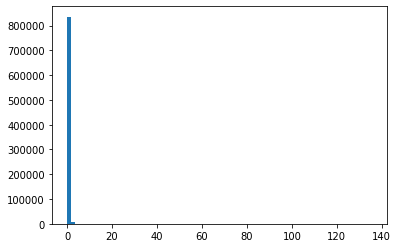

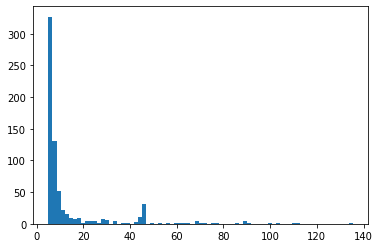

In [0]:
#TO DO: add labels
plt.hist(df['Duration'].values, bins=75)
plt.show() 
plt.hist(df[df['Duration'] > 5 ]['Duration'].values, bins=75)
plt.show() 


### Have a look at the times and dates that the system has come under attack:
- Convert the 'Date first seen' column to a datetime object (see code in Appendix).


In [0]:
df['Date first seen'] = pd.to_datetime(df['Date first seen'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 845152 entries, 23 to 8451510
Data columns (total 16 columns):
Date first seen      845152 non-null datetime64[ns]
Duration             845152 non-null float64
Proto                845152 non-null object
Src IP Addr          845152 non-null object
Src Pt               845152 non-null int64
Dst IP Addr          845152 non-null object
Dst Pt               845152 non-null float64
Packets              845152 non-null int64
Bytes                845152 non-null object
Flows                845152 non-null int64
Flags                845152 non-null object
Tos                  845152 non-null int64
class                845152 non-null object
attackType           845152 non-null object
attackID             845152 non-null object
attackDescription    845152 non-null object
dtypes: datetime64[ns](1), float64(2), int64(4), object(9)
memory usage: 109.6+ MB


- Create new columns for the day-of-week or time-of-day.


In [0]:
df['Day of week'] = df['Date first seen'].dt.dayofweek
df['Time of day'] = df['Date first seen'].dt.hour
print(df['Day of week'].unique())
print(df['Time of day'].unique())

[2 3 4 5 6 0 1]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


- Plot histograms of the day-of-week and of the time-of-day to see their distribution in the data.


(array([167174., 155030.,      0., 150140.,      0., 143468., 188417.,
             0.,  28414.,  12509.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

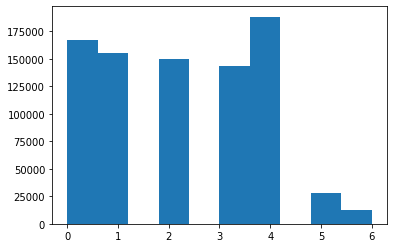

In [0]:
#TO DO: add labels
plt.hist(df['Day of week'].values)

#fig, ax = plt.subplots()
#ax.hist(df['accountAgeDays'].values, bins=20)
#ax.set_xlabel('accountAgeDays')
#plt.show()

(array([  9195.,   5729.,  35311., 130421., 137114., 191961., 235513.,
         79557.,  12900.,   7451.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

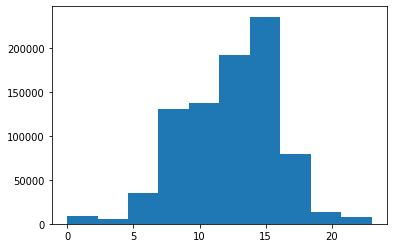

In [0]:
#TO DO: add labels
plt.hist(df['Time of day'].values)

- Select only the rows corresponding to attacks and replot the histograms.


(array([36270.,     0., 23288.,     0.,     0., 16585.,     0.,  8981.,
            0., 59515.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

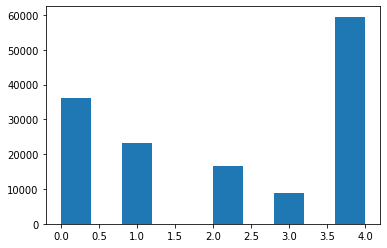

In [0]:
#TO DO: add labels
plt.hist(df[(df['class']=="attacker")| (df['class']=="victim")]['Day of week'].values)

(array([  555.,   390.,   372.,  8565., 11946., 63391., 56617.,  1908.,
          565.,   330.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

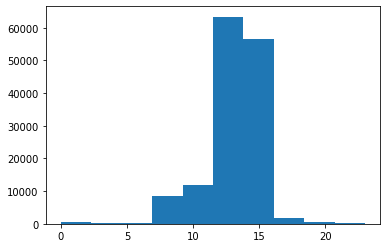

In [0]:
#TO DO: add labels
plt.hist(df[(df['class']=="attacker")| (df['class']=="victim")]['Time of day'].values)

- Does the day-of-week or time-of-day affect the probability of seeing an attack?

Yes! 

Some other visualization:

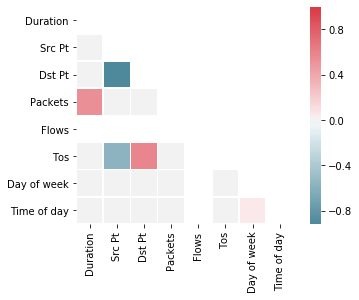

In [0]:
#Sometimes our features may be closely related to other features. We can easily calculate the correlation coefficient between pairs of features.

corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, center=0, vmax=1);

In [0]:
feature_desc = {'Duration': 'Duration', 'Packets': 'Packets','Day of week' : 'Day of week','Time of day':'Time of day'}
def plot_feature(column):
    plt.plot(df[column], df['class'], '.')
    plt.xlabel(feature_desc[column])
    plt.ylabel('Class')

dropdown_menu = {v: k for k, v in feature_desc.items()}

widgets.interact(plot_feature, column=dropdown_menu);
#no attaks on weekends
#unbalanced features

interactive(children=(Dropdown(description='column', options={'Duration': 'Duration', 'Packets': 'Packets', 'D…

### Now create some classifiers using just the numeric attributes and try to predict the ‘class’:
- Train a logistic regression classifier.


In classification, we predict categorical labels. In regression, we predict quantitative/numerical labels. The critical difference is that we can't take a difference between the predicted and actual category in classification, while we can take a difference between the predicted and actual numerical values in regression. Because of these differences between regression and classification, we use different metrics to evaluate machine learning models trained for classification.

As with regression, we're trying to determine the model $f$ that can best describes the relationship

$$ y_j = f(X_j). $$

For classification, $y_j$ can only take a finite set of values. If there are only two such values, we are dealing with **binary** classification. Examples of binary classification are predicting whether it will rain or not and whether someone will default on their loan. If we have more than two classes, we have a **multiclass** problem. For example, image classification is usually multiclass as we are trying to identify an image among a set of values, e.g., a person, a road sign, a car, etc.

In [0]:
X_train,  X_test, y_train, y_test = train_test_split(
    df[['Duration', 'Packets']],  
    df[['class']], 
    test_size=0.20
)

The logistic regression model is the classifier version of linear regression. It is a probabilistic model; it will predict probability values that can then be used to assign class labels. The model works by taking the output of a linear regression model and feeds it into a sigmoid or logistic function. Mathematically

$$ p_j = S\left( \sum_{i} X_{ji}\beta_i  + \beta_0 \right), $$
where
$$ S(x) = \frac{1}{1 + e^{-x}} $$

The reason for the sigmoid function is that it maps values that range from positive to negative infinity to values that only range from 0 to 1. Thus, the output of the sigmoid function can be interpreted as a probability.

The $\beta$ coefficients of the model are chosen to minimize the log loss. Unlike linear regression, there is no closed-form solution to the optimal coefficient. Instead, the coefficients are solved using gradient descent.

In [0]:
from sklearn.linear_model import LogisticRegression

# define the classifier
clf_lr = LogisticRegression(solver='lbfgs', max_iter=1500, verbose=1, n_jobs=-1,multi_class='multinomial')

# train the classifier
t0 = time.time()
clf_lr.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))
y_pred_lr = clf_lr.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


elapsed time = 34.60


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   33.2s finished


- How well does the classifier perform in terms of accuracy on the TRAINING data?


A natural choice for a metric for classification is accuracy. Accuracy is equal to the number of observations you correctly classified over all observations. For example, if your model properly identified 77 out of 100 images, you have an accuracy of 77%. Accuracy is an easy metric to both understand and calculate. Mathematically, it is simply

$$ \frac{\text{number of correct observations}}{\text{number of observations}}.$$

However, accuracy may not always be a good metric. Consider the case of disease detection where only 10% of the observations have the disease. A naive classifier that always predicts the majority class will achieve 90% accuracy. 
While the naive model correctly identifies everyone without the disease, it fails to identify any person with the disease. We need a metric that will tell us how well our model performs for a particular class.

For the example of disease detection, we are more interested in determining our model's performance with regards to the class representing having the disease. Let's call this class  **positive** and not having the disease as **negative**. Particularly, we want to know what fraction of all positive predictions were correct and what fraction of positive observations did we identify. The two metrics that describe these values are precision and recall. Precision is the fraction of true positives over all positive predictions. It is a measure of how "precise" our model was with regards to labeling observations as positive. Recall, on the other hand, is equal to the fraction of true positives over all positive observations. It is a measure of our model's ability to "catch" and properly label observations that are positive.

A confusion matrix is a table summarizing the performance of the model by enumerating true and false positives and the true and false negatives.

|                     | Positive Observation     | Negative Observation    |
|---------------------|:------------------------:|:-----------------------:|
| Positive Prediction |     True Positive (TP)   | False Positive (FP)     |
| Negative Prediction | False Negative (FN)      |     True Negative (TN)  |

Given the definitions used earlier, the equation for precision and recall are

$$ \text{precision} = \frac{\text{TP}}{TP + FP}$$
and
$$ \text{recall} = \frac{\text{TP}}{TP + FN}. $$

Note, the difference between the metrics is their denominator. In our disease detection example, if we labeled 12 observations as positive but only 8 were actually true positives, our precision is 0.667. If our data set had 10 positive observations, since we correctly identified or "recalled" 8 of them, our recall is 0.8. If we had used the naive model that predicts the majority class, the recall would be 0 and our precision would be undefined.

What is more important, precision or recall? The answer depends on the specifics of the problem. Having a model that prioritizes less false positives will have a higher precision and a model that aims to reduce the number of false negatives will have a higher recall. You must decide whether your model should prioritize reducing false positives or false negatives. It is often helpful to consider the cost, whether financial, societal, etc., of your model making false positives and false negatives.

In [0]:
print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_lr)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_lr,average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_lr, average='macro')))
print(metrics.classification_report(y_test, y_pred_lr))

NameError: ignored

- Load data from the second week and use it as TEST data.


In [0]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1GlIcKxKYsSY9QfRINrGBSDtEhyOwWuMa'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CIDDS-001-internal-week2_10pcSample.csv')  
df_test = pd.read_csv('CIDDS-001-internal-week2_10pcSample.csv',index_col=[0],dtype={'Bytes': object})
df_test.head(5)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,attackID,attackDescription
12,2017-03-22 00:00:11.767,0.004,TCP,192.168.220.5,55126,192.168.100.5,445.0,2,174,1,.AP...,0,normal,---,---,---
11,2017-03-22 00:00:11.768,0.000,TCP,192.168.100.5,445,192.168.220.5,55126.0,1,108,1,.AP...,0,normal,---,---,---
29,2017-03-22 00:00:27.207,0.232,TCP,192.168.200.8,58749,EXT_SERVER,8082.0,2,319,1,.AP...,0,normal,---,---,---
36,2017-03-22 00:00:32.830,0.000,UDP,192.168.210.5,50947,DNS,53.0,1,81,1,......,0,normal,---,---,---
51,2017-03-22 00:00:46.964,0.000,TCP,10179_174,443,192.168.210.5,51433.0,1,54,1,.A....,32,normal,---,---,---


In [0]:
y_pred_lr_test = clf_lr.predict(df_test[['Duration', 'Packets']])

- How well does the classifier perform (in terms of accuracy) on the TEST data?


In [0]:
print("accuracy: {}".format(metrics.accuracy_score(df_test[['class']], y_pred_lr_test)))
print("precision: {:g}".format(metrics.precision_score(df_test[['class']], y_pred_lr_test,average='macro')))
print("recall: {:g}".format(metrics.recall_score(df_test[['class']], y_pred_lr_test, average='macro')))
print(metrics.classification_report(df_test[['class']], y_pred_lr_test))

accuracy: 0.8261257932270557


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision: 0.275377
recall: 0.333331


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    attacker       0.00      0.00      0.00     91009
      normal       0.83      1.00      0.90    851802
      victim       0.00      0.00      0.00     88262

    accuracy                           0.83   1031073
   macro avg       0.28      0.33      0.30   1031073
weighted avg       0.68      0.83      0.75   1031073



- Is that performance good? Print out confusion matrices to better understand the results.

In [0]:
metrics.confusion_matrix(df_test[['class']], y_pred_lr_test)


array([[     0,  91009,      0],
       [     6, 851796,      0],
       [     0,  88262,      0]])

Now let's optimize a bit this model. 

In [0]:
df['Bytes']= df['Bytes'].apply(lambda r: float(r) if 'M' not in r else float(r.replace('M',''))*1000000)

In [0]:
df_test['Bytes']= df_test['Bytes'].apply(lambda r: float(r) if 'M' not in r else float(r.replace('M',''))*1000000)

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# define the classifier
clf_lr_op = LogisticRegression(solver='lbfgs', verbose=1, n_jobs=-1, multi_class='multinomial')

X_train,  X_test, y_train, y_test = train_test_split(
    df[['Duration', 'Packets', 'Bytes']],  
    df[['class']], 
    test_size=0.20
)

pipe = Pipeline(steps=[('clf_lr_op', clf_lr_op)])
param_grid = {
    'clf_lr_op__max_iter': [50, 100, 1000]
}
t0 = time.time()
searchLR = GridSearchCV(pipe, param_grid, iid=False, cv=3, verbose=True, n_jobs=-1)
searchLR.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))
print(searchLR.best_params_)
trainedLR = searchLR.best_estimator_.get_params()['clf_lr_op']
y_pred_LR = trainedLR.predict(X_test)

print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_LR)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_LR,average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_LR, average='macro')))
print(metrics.classification_report(y_test, y_pred_LR))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  3.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   28.7s finished


elapsed time = 215.87
{'clf_lr_op__max_iter': 50}
accuracy: 0.8283746768344268


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision: 0.276151
recall: 0.333295


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    attacker       0.00      0.00      0.00     15068
      normal       0.83      1.00      0.91    140037
      victim       0.00      0.00      0.00     13926

    accuracy                           0.83    169031
   macro avg       0.28      0.33      0.30    169031
weighted avg       0.69      0.83      0.75    169031



### Compare performance across different classifiers:
- Try a Decision Tree and a Random Forest. Does the performance improve? Why?


elapsed time = 1.61
accuracy: 0.9760458140814406
precision: 0.943489
recall: 0.950233
              precision    recall  f1-score   support

    attacker       0.97      0.97      0.97     14955
      normal       0.99      0.98      0.99    140208
      victim       0.87      0.89      0.88     13868

    accuracy                           0.98    169031
   macro avg       0.94      0.95      0.95    169031
weighted avg       0.98      0.98      0.98    169031

accuracy: 0.9812729069619707
precision: 0.949505
recall: 0.973936
              precision    recall  f1-score   support

    attacker       0.98      0.98      0.98     91009
      normal       0.99      0.98      0.99    851802
      victim       0.88      0.96      0.92     88262

    accuracy                           0.98   1031073
   macro avg       0.95      0.97      0.96   1031073
weighted avg       0.98      0.98      0.98   1031073



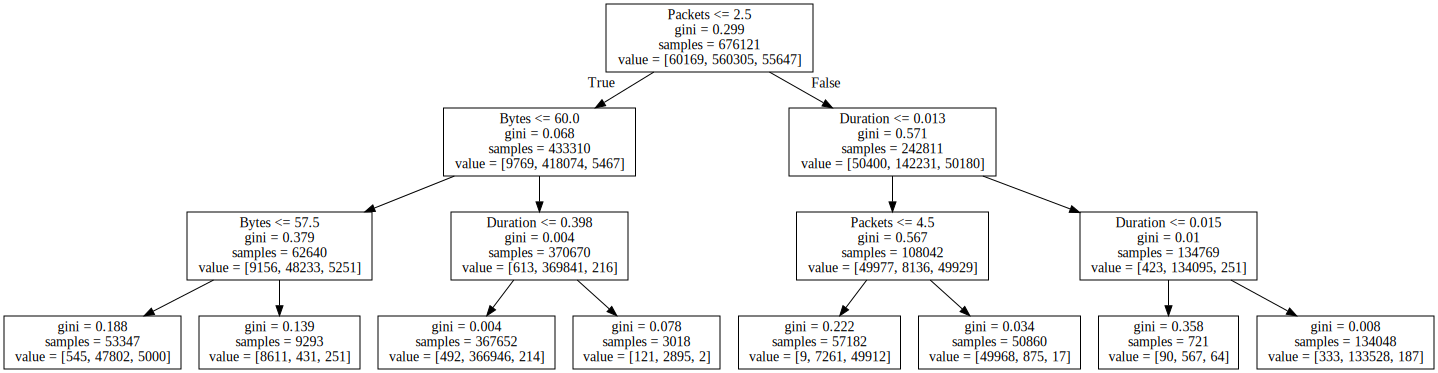

In [0]:
!pip install graphviz
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz

X_train,  X_test, y_train, y_test = train_test_split( 
    df[['Duration', 'Packets', 'Bytes']],  
    df[['class']], 
    test_size=0.20
)

# define the classifier
clf_dt = DecisionTreeClassifier(max_depth=3)

# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_dt = clf_dt.predict(X_test)


print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt,average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt))

y_pred_dt = clf_dt.predict(df_test[['Duration', 'Packets', 'Bytes']])
print("accuracy: {}".format(metrics.accuracy_score(df_test[['class']], y_pred_dt)))
print("precision: {:g}".format(metrics.precision_score(df_test[['class']], y_pred_dt,average='macro')))
print("recall: {:g}".format(metrics.recall_score(df_test[['class']], y_pred_dt, average='macro')))
print(metrics.classification_report(df_test[['class']], y_pred_dt))

# visual tree
from sklearn import tree
graphviz.Source(export_graphviz(clf_dt, 
                                out_file=None,
                                feature_names=list(X_train.columns.values)))

In [0]:

X_train,  X_test, y_train, y_test = train_test_split(
    df[['Duration', 'Packets','Bytes']],  
    df[['class']], 
    test_size=0.20
)
from sklearn.ensemble import RandomForestClassifier
# define the classifier
clf_rf = RandomForestClassifier(n_estimators=700, n_jobs=-1, verbose=1)

# train the classifier
t0 = time.time()
clf_rf.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_rf = clf_rf.predict(X_test)

print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_rf)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_rf,average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_rf, average='macro')))
print(metrics.classification_report(y_test, y_pred_rf))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


elapsed time = 163.51


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    5.8s finished


accuracy: 0.9901379036981383
precision: 0.991985
recall: 0.963091
              precision    recall  f1-score   support

    attacker       0.99      0.99      0.99     14940
      normal       0.99      1.00      0.99    140124
      victim       1.00      0.90      0.95     13967

    accuracy                           0.99    169031
   macro avg       0.99      0.96      0.98    169031
weighted avg       0.99      0.99      0.99    169031



- How does GaussianNB perform on the numeric features?


In [0]:

#map class to numeric thing
X_train,  X_test, y_train, y_test = train_test_split( #https://stackoverflow.com/questions/47321709/how-to-split-train-and-test-dataset-to-x-train-y-train-and-x-test-y-test
    df[['Duration', 'Packets','Bytes']],  
    df[['class']], 
    test_size=0.20
)
from sklearn.naive_bayes import GaussianNB
# define the classifier
clf_nb = GaussianNB()

# train the classifier
t0 = time.time()
clf_nb.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_nb = clf_nb.predict(X_test)

print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_nb)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_nb,average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_nb, average='macro')))
print(metrics.classification_report(y_test, y_pred_nb))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


elapsed time = 1.47
accuracy: 0.2611946920978992
precision: 0.500422
recall: 0.653645
              precision    recall  f1-score   support

    attacker       0.39      0.84      0.53     15003
      normal       1.00      0.13      0.23    140247
      victim       0.12      1.00      0.21     13781

    accuracy                           0.26    169031
   macro avg       0.50      0.65      0.32    169031
weighted avg       0.87      0.26      0.25    169031



- Beware running the SVM classifier: There is a lot of data here, so you would need to use a linear SVM rather than an RBF one, (and even then it may run out of memory without adjustments).


In [0]:
from sklearn.svm import LinearSVC
# define the classifier
clf_svc = LinearSVC(kernel='linear',verbose=True)

# train the classifier
t0 = time.time()
clf_svc.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction 
y_pred_svc = clf_svc.predict(X_test)

print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_svc)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_svc,average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_svc, average='macro')))
print(metrics.classification_report(y_test, y_pred_svc))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


- Convert the class to a binary attribute (malicious vs benign) and compute precision and recall values.
Anything of note?

In [0]:
df['classBin']= df['class'].apply(lambda x: 'benign' if x == 'normal' else 'malicious')

In [0]:
from sklearn.model_selection import train_test_split

X_train,  X_test, y_train, y_test = train_test_split( 
    df[['Duration', 'Packets', 'Bytes']],  
    df[['classBin']], 
    test_size=0.20
)

from sklearn.linear_model import LogisticRegression

# define the classifier
clf_lr_bin = LogisticRegression(solver='lbfgs', max_iter=50, verbose=1, n_jobs=-1)

# train the classifier
t0 = time.time()
clf_lr_bin.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))
y_pred_lr_bin = clf_lr_bin.predict(X_test)

print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_lr_bin)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_lr_bin, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_lr_bin, average='macro')))
print(metrics.classification_report(y_test, y_pred_lr_bin))
df=df.drop(['classBin'], axis=1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.1s finished


elapsed time = 6.01
accuracy: 0.8281262017026463
precision: 0.414085
recall: 0.499968
              precision    recall  f1-score   support

      benign       0.83      1.00      0.91    139988
   malicious       0.00      0.00      0.00     29043

    accuracy                           0.83    169031
   macro avg       0.41      0.50      0.45    169031
weighted avg       0.69      0.83      0.75    169031



In [0]:
#it gets better, logistic regression works better with binary attributes

### Predicting another target:
- Rather than predicting the class variable, try to predict the “attackType” variable.


In [0]:
from sklearn.model_selection import train_test_split
#map class to numeric thing
X_train,  X_test, y_train, y_test = train_test_split( #https://stackoverflow.com/questions/47321709/how-to-split-train-and-test-dataset-to-x-train-y-train-and-x-test-y-test
    df[['Duration', 'Packets','Bytes']],  
    df[['attackType']], 
    test_size=0.20
)

from sklearn.tree import DecisionTreeClassifier
# define the classifier
clf_dt = DecisionTreeClassifier(max_depth=5)

# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_dt_at = clf_dt.predict(X_test)


print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt_at)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt_at, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt_at, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt_at))


elapsed time = 1.65
accuracy: 0.983949689701889


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision: 0.782482
recall: 0.538706


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         ---       0.98      1.00      0.99    140196
  bruteForce       0.00      0.00      0.00        42
         dos       0.98      0.97      0.98     24973
    pingScan       1.00      0.11      0.20        63
    portScan       0.94      0.61      0.74      3757

    accuracy                           0.98    169031
   macro avg       0.78      0.54      0.58    169031
weighted avg       0.98      0.98      0.98    169031



- Is that variable easier/harder to predict?


In [0]:
#it's harder, any model tested have worse performances
#TO DO: explain better

- The data is quite unbalanced. You could try to rebalance it by randomly down-sampling the majority class. Does it improve accuracy on the (not-down sampled) test data?

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

X_train,  X_test, y_train, y_test = train_test_split(
    df[['Duration', 'Packets', 'Bytes']],  
    df[['class']], 
    test_size=0.20
)
#TO DO: fix scaling!! Use resampling!
standard_scaler = StandardScaler().fit(X_train[['Duration', 'Packets', 'Bytes']])

X_train[['Duration', 'Packets', 'Bytes']] = standard_scaler.transform(X_train[['Duration', 'Packets', 'Bytes']])
X_test[['Duration', 'Packets', 'Bytes']] = standard_scaler.transform(X_test[['Duration', 'Packets', 'Bytes']])
# define the classifier
clf_lr = LogisticRegression(solver='lbfgs', max_iter=1500, verbose=1, n_jobs=-1,multi_class='multinomial')

# train the classifier
t0 = time.time()
clf_lr.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))
y_pred_lr = clf_lr.predict(X_test)

print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_lr)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_lr,average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_lr, average='macro')))
print(metrics.classification_report(y_test, y_pred_lr))


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   22.2s finished


elapsed time = 23.51
accuracy: 0.8279013908691305


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision: 0.275972
recall: 0.333326


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    attacker       0.00      0.00      0.00     14943
      normal       0.83      1.00      0.91    139944
      victim       0.00      0.00      0.00     14144

    accuracy                           0.83    169031
   macro avg       0.28      0.33      0.30    169031
weighted avg       0.69      0.83      0.75    169031



### Introducing more features:
- Introduce other features to the classifiers to see if you can further improve performance …


In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# define the classifier
clf_lr_op = LogisticRegression(solver='lbfgs', verbose=1, n_jobs=-1)

df_one_hot = pd.get_dummies(df, columns=['Proto','Tos'])  
X_train,  X_test, y_train, y_test = train_test_split(
    df_one_hot.drop(['Date first seen','Src IP Addr','Src Pt','Dst IP Addr','Dst Pt','Flags','class','attackType','attackID','attackDescription','Day of week','Time of day'],axis=1),
    df_one_hot[['class']], 
    test_size=0.20
)
    
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# define the classifier
clf_dt = DecisionTreeClassifier(max_depth=5)

# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_dt_at = clf_dt.predict(X_test)


print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt_at)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt_at, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt_at, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt_at))



elapsed time = 2.07
accuracy: 0.986446273168827
precision: 0.980213
recall: 0.957741
              precision    recall  f1-score   support

    attacker       0.99      0.98      0.99     15083
      normal       0.99      1.00      0.99    140073
      victim       0.96      0.90      0.93     13875

    accuracy                           0.99    169031
   macro avg       0.98      0.96      0.97    169031
weighted avg       0.99      0.99      0.99    169031



- Try adding day-of-week and time-of-day features into the classifier. Do they improve the performance?


In [0]:
from sklearn.model_selection import train_test_split
#map class to numeric thing

X_train,  X_test, y_train, y_test = train_test_split(
    df_one_hot.drop(['Date first seen','Src IP Addr','Src Pt','Dst IP Addr','Dst Pt','Flags','class','attackType','attackID','attackDescription'],axis=1),
    df_one_hot[['class']], 
    test_size=0.20
)

import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# define the classifier
clf_dt = DecisionTreeClassifier(max_depth=7)

# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_dt_at = clf_dt.predict(X_test)


print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt_at)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt_at, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt_at, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt_at))



elapsed time = 2.72
accuracy: 0.9892978211097373
precision: 0.988008
recall: 0.963371
              precision    recall  f1-score   support

    attacker       0.99      0.99      0.99     15013
      normal       0.99      1.00      0.99    139920
      victim       0.98      0.90      0.94     14098

    accuracy                           0.99    169031
   macro avg       0.99      0.96      0.98    169031
weighted avg       0.99      0.99      0.99    169031



- Split the “Flags” column up into separate columns for each of the flags (see code below for how to do that) and then make use of the flags as features. Do they improve the performance?


In [0]:
df_one_hot['Flag_1'] = [x[0] for x in df_one_hot['Flags']]
df_one_hot['Flag_2'] = [x[1] for x in df_one_hot['Flags']]
df_one_hot['Flag_3'] = [x[2] for x in df_one_hot['Flags']]
df_one_hot['Flag_4'] = [x[3] for x in df_one_hot['Flags']]
df_one_hot['Flag_5'] = [x[4] for x in df_one_hot['Flags']]
df_one_hot['Flag_6'] = [x[5] for x in df_one_hot['Flags']]
df_one_hot = pd.get_dummies(df_one_hot, columns=['Flag_1','Flag_2','Flag_3','Flag_4','Flag_5','Flag_6'])
df_one_hot.head(5)

,Date first seen,Duration,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,class,attackType,attackID,attackDescription,Day of week,Time of day,Proto_ICMP,Proto_IGMP,Proto_TCP,Proto_UDP,Tos_0,Tos_12,Tos_16,Tos_32,Tos_192,Flag_1_.,Flag_2_.,Flag_2_A,Flag_3_.,Flag_3_P,Flag_4_.,Flag_4_R,Flag_5_.,Flag_5_S,Flag_6_.,Flag_6_F
23,2017-03-15 00:01:17.728,0.047,192.168.220.16,45586,10000_35,443.0,5,906.0,1,.AP.S.,normal,---,---,---,2,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1,1,0
36,2017-03-15 00:01:18.457,0.170,10003_195,80,192.168.220.16,48286.0,3,908.0,1,.AP.S.,normal,---,---,---,2,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0
30,2017-03-15 00:01:18.511,0.003,10002_113,443,192.168.220.16,49062.0,2,1089.0,1,.AP...,normal,---,---,---,2,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,1,0,1,0
46,2017-03-15 00:01:22.400,0.000,EXT_SERVER,8082,192.168.220.15,37039.0,1,212.0,1,.AP...,normal,---,---,---,2,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,1,0,1,0
51,2017-03-15 00:01:24.152,0.266,192.168.200.9,52290,EXT_SERVER,8082.0,2,319.0,1,.AP...,normal,---,---,---,2,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,1,0,1,0


In [0]:

X_train,  X_test, y_train, y_test = train_test_split(
    df_one_hot.drop(['Date first seen','Src IP Addr','Src Pt','Dst IP Addr','Dst Pt','Flags','class','attackType','attackID','attackDescription'],axis=1),
    df_one_hot[['class']], 
    test_size=0.20
)

import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# define the classifier
clf_dt = DecisionTreeClassifier(max_depth=7)

# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_dt_at = clf_dt.predict(X_test)


print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt_at)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt_at, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt_at, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt_at))

elapsed time = 3.10
accuracy: 0.9975803255024226
precision: 0.99305
recall: 0.99599
              precision    recall  f1-score   support

    attacker       1.00      0.99      1.00     15018
      normal       1.00      1.00      1.00    139927
      victim       0.98      1.00      0.99     14086

    accuracy                           1.00    169031
   macro avg       0.99      1.00      0.99    169031
weighted avg       1.00      1.00      1.00    169031



- Source IP addresses can be one of four categories (code in the appendix can be used to map IP addresses to the categories). Are the categories useful features?

In [0]:
def get_IP_category(ip_addr):
  if ip_addr == 'DNS':
    return 'DNS'
  elif ip_addr == 'EXT_SERVER':
    return 'EXT_SERVER'
  elif len(ip_addr.split('.')) == 4:
    return 'private'
  elif len(ip_addr.split('_')) == 2:
    return 'public'
  else:
    return '-'

df_one_hot['Src IP Addr Cat']= df_one_hot['Src IP Addr'].apply(lambda x: get_IP_category(x))
df_one_hot = pd.get_dummies(df_one_hot, columns=['Src IP Addr Cat'])

from sklearn.model_selection import train_test_split

X_train,  X_test, y_train, y_test = train_test_split(
    df_one_hot.drop(['Date first seen','Src Pt','Src IP Addr','Dst IP Addr','Dst Pt','Flags','class','attackType','attackID','attackDescription'],axis=1),
    df_one_hot[['class']], 
    test_size=0.20
)
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# define the classifier
clf_dt = DecisionTreeClassifier(max_depth=7)

# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_dt_at = clf_dt.predict(X_test)

print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt_at)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt_at, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt_at, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt_at))

elapsed time = 3.31
accuracy: 0.9978702131561666
precision: 0.993911
recall: 0.99629
              precision    recall  f1-score   support

    attacker       1.00      0.99      1.00     14969
      normal       1.00      1.00      1.00    140147
      victim       0.99      1.00      0.99     13915

    accuracy                           1.00    169031
   macro avg       0.99      1.00      1.00    169031
weighted avg       1.00      1.00      1.00    169031



No. Or not so much at least. I mean we are still ok.

### Creating counts
- When detecting a Denial of Service (DoS) or portScan attack, counts of the number of requests from the same Source IP Address within a given time window could be an important feature. (For a DDoS attack, the same may be true of Destination IP Addresses.)


In [0]:
#def countingProcedure(param)
#if dos or portScan then 
#df['Cum Count Src IP Addr (Number of seconds)'] = df.groupby(['Src IP Addr', pd.Grouper(freq='10S',
#key='Date first seen')]).cumcount()


- Try adding one or more count fields to the dataset using the code from the Appendix.


In [0]:
df_one_hot['Cum Count Src IP Addr (10seconds)'] = df_one_hot.groupby(['Src IP Addr', pd.Grouper(freq='10S',
key='Date first seen')]).cumcount()
df_one_hot['Cum Count Src IP Addr (20seconds)'] = df_one_hot.groupby(['Src IP Addr', pd.Grouper(freq='20S',
key='Date first seen')]).cumcount()
df_one_hot['Cum Count Src IP Addr (60seconds)'] = df_one_hot.groupby(['Src IP Addr', pd.Grouper(freq='60S',
key='Date first seen')]).cumcount()


X_train,  X_test, y_train, y_test = train_test_split(
    df_one_hot.drop(['Date first seen','Src Pt','Src IP Addr','Dst IP Addr','Dst Pt','Flags','class','attackType','attackID','attackDescription'],axis=1),
    df_one_hot[['class']], 
    test_size=0.20
)

from sklearn.tree import DecisionTreeClassifier
# define the classifier
clf_dt = DecisionTreeClassifier(max_depth=7)

# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_dt_at = clf_dt.predict(X_test)

print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt_at)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt_at, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt_at, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt_at))

elapsed time = 4.07
accuracy: 0.9953322171672652
precision: 0.994096
recall: 0.985463
              precision    recall  f1-score   support

    attacker       1.00      0.98      0.99     14950
      normal       1.00      1.00      1.00    140265
      victim       0.99      0.98      0.98     13816

    accuracy                           1.00    169031
   macro avg       0.99      0.99      0.99    169031
weighted avg       1.00      1.00      1.00    169031



- Does the count field improve performance of the classifiers? What window or windows make sense?

In [0]:
# Not all of them
# N second is the best time window (try to rain with separate count fields)

### Think about other analysis you could perform on the data:
- What other features might be interesting? Try to compute them by modifying the code in the Appendix.


In [0]:
#add features 
#possible feature is weekday or weekend

X_train,  X_test, y_train, y_test = train_test_split(
    df_one_hot.drop(['Date first seen','Src IP Addr','Dst IP Addr','Flags','class','attackType','attackID','attackDescription'],axis=1),
    df_one_hot[['class']], 
    test_size=0.20
)

# define the classifier
clf_dt = DecisionTreeClassifier(max_depth=7)

# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_dt_at = clf_dt.predict(X_test)

print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt_at)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt_at, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt_at, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt_at))

elapsed time = 5.06
accuracy: 0.9966574178700949
precision: 0.997572
recall: 0.988137
              precision    recall  f1-score   support

    attacker       1.00      0.98      0.99     15081
      normal       1.00      1.00      1.00    139943
      victim       1.00      0.98      0.99     14007

    accuracy                           1.00    169031
   macro avg       1.00      0.99      0.99    169031
weighted avg       1.00      1.00      1.00    169031



- Try running some other analysis like clustering on the data.

In [0]:
from sklearn.cluster import (
    KMeans, 
    AgglomerativeClustering, 
    DBSCAN
)
from sklearn.metrics import (
    homogeneity_score,
    completeness_score,
    v_measure_score
)

kmeans = KMeans(n_clusters=3).fit(
    df_one_hot.drop(['Date first seen','Src IP Addr','Dst IP Addr','Flags','class','attackType','attackID','attackDescription'],axis=1),
)
print(kmeans.cluster_centers_)
df_one_hot['cluster'] = kmeans.labels_
print(df_one_hot.groupby(['cluster', 'class']).size().reset_index().sort_values(['cluster', 'class']))

predicted_clusters = df_one_hot['cluster'].values
true_labels = df_one_hot['class'].values
print(homogeneity_score(true_labels, predicted_clusters))
print(completeness_score(true_labels, predicted_clusters))
print(v_measure_score(true_labels, predicted_clusters))

NameError: ignored

In [0]:
#AgglomerativeClustering
agglomerative = AgglomerativeClustering(n_clusters=k).fit(df_one_hot.drop(['Date first seen','Src IP Addr','Dst IP Addr','Flags','class','attackType','attackID','attackDescription'],axis=1))
print(v_measure_values.append(v_measure_score(df_one_hot['label'].values, agglomerative.labels_)))
#DBSCAN


NameError: ignored

# APPENDIX
Some code to help with some of the tasks in part 1 of the assignment:
- Converting column from string to datetime format:

In [0]:
#df1['Date first seen'] = pd.to_datetime(df1['Date first seen'])

Getting time-of-day and day-of-week features from datetime object:

In [0]:
#df1['Date first seen'].dt.dayofweek
#df1['Date first seen'].dt.hour

Splitting the Flags field into separate fields:

In [0]:
#df1["Flag_1"] = [x[0] for x in df1["Flags"]]
#df1["Flag_2"] = [x[1] for x in df1["Flags"]]
#df1["Flag_3"] = [x[2] for x in df1["Flags"]]
#df1["Flag_4"] = [x[3] for x in df1["Flags"]]
#df1["Flag_5"] = [x[4] for x in df1["Flags"]]
#df1["Flag_6"] = [x[5] for x in df1["Flags"]]

Code for assigning Source IPs to 4 categories:

In [0]:
#def get_IP_category(ip_addr):
#if ip_addr == 'DNS':
#return 'DNS'
#elif ip_addr == 'EXT_SERVER':
#return 'EXT_SERVER'
#elif len(ip_addr.split('.')) == 4:
#return 'private'
#elif len(ip_addr.split('_')) == 2:
#return 'public'
#else:
#return '-'

Create new column with count of requests from same ‘Src IP Addr’ over the last 10 seconds:

In [0]:
#df1['Cum Count Src IP Addr (10seconds)'] = df1.groupby(['Src IP Addr', pd.Grouper(freq='10S',
#key='Date first seen')]).cumcount()

#*Sara Imbeni*

# *Giacomo Minello*

#*Utkan Peker*